In [51]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


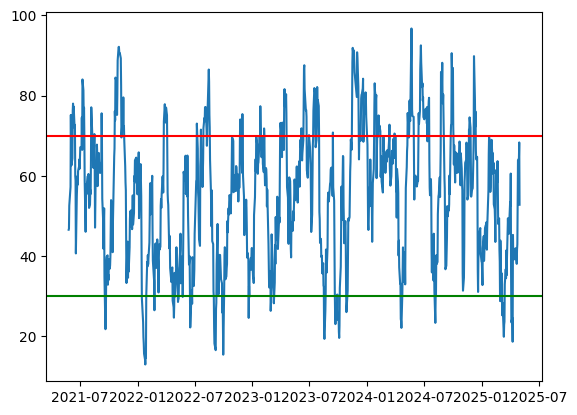

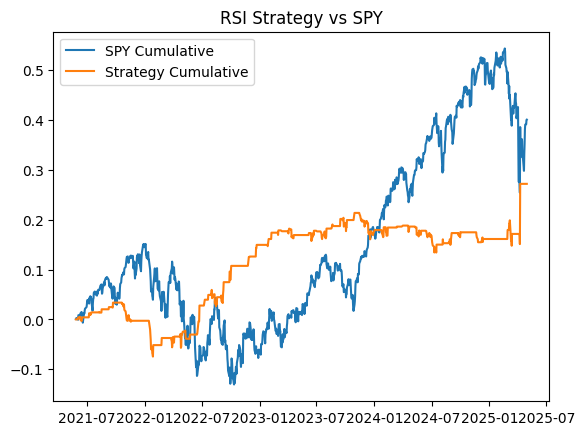

In [52]:
TICKER = 'SPY'
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 1000

def get_data(ticker=TICKER):
    df = yf.download(ticker)
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-LOOKBACK:, :]

def add_RSI(df, length=RSI_LENGTH):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')

    return df.dropna()

def add_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['Strategy'] = 0
    df['Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    # plot the strategy returns

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', 'Strategy Cumulative'])
    plt.title(F'RSI Strategy vs {TICKER}');

    return df

def main():
    df = get_data()
    df = add_RSI(df)
    df = add_strategy(df)
    df = test_strategy(df)
    return df

df = main()